# 5‑4  Finite Differences – Reference Solutions

This notebook accompanies Section **5.4 – Finite Differences** from *Fundamentals of Numerical Computation*.  It implements the programming exercises with Python/NumPy **(no Julia)**. A lightweight `fdweights` routine based on a Vandermonde system is used in place of the Julia `fdweights` helper.

In [1]:
import numpy as np
import math, mpmath as mp
import matplotlib.pyplot as plt

import numpy as np
from functools import lru_cache

def fdweights(t, m):
    """5-4
    Compute weights for the `m`th derivative of a function at zero using
    values at the nodes in vector `t`.
    """
    t = np.asarray(t, dtype=float)
    r = len(t) - 1          # highest node index

    @lru_cache(maxsize=None)
    def weight(m_, r_, k_):
        # Recursively compute a single weight.
        if m_ < 0 or m_ > r_:
            return 0.0
        if m_ == 0 and r_ == 0:
            return 1.0
        if k_ < r_:
            # “interior” recursion branch
            return (t[r_] * weight(m_, r_-1, k_) -
                    m_    * weight(m_-1, r_-1, k_)) / (t[r_] - t[k_])
        else:
            # k_ == r_  →  “last-node” recursion branch
            numer = np.prod(t[r_-1] - t[:r_-1]) if r_ > 1 else 1.0
            denom = np.prod(t[r_]   - t[:r_])   if r_ > 0 else 1.0
            beta  = numer / denom
            return beta * (m_ * weight(m_-1, r_-1, r_-1)
                           - t[r_-1] * weight(m_, r_-1, r_-1))

    return np.array([weight(m, r, k) for k in range(r + 1)], dtype=float)


## Exercise 2(b) – Second‑order derivative estimates at three nodes
Nodes: $t=0.9,\;1.0,\;1.1$ with spacing $h=0.1$;  function $f(x)=\sin(2x)$.

- At $x=0.9$: **forward** formula of order 2, weights $(-\tfrac{3}{2},2,-\tfrac12)/h$.
- At $x=1.0$: **centered** formula of order 2, weights $(-\tfrac12,0,\tfrac12)/(2h)$.
- At $x=1.1$: **backward** formula of order 2, obtained by reversing the forward weights.


In [2]:
f = lambda x: np.sin(2*x)
h = 0.1
nodes = np.array([0.9, 1.0, 1.1])

# Forward diff (order 2) at leftmost node
w_fwd = np.array([-1.5, 2.0, -0.5]) / h
fp_09 = np.dot(w_fwd, f(nodes))

# Centered diff (order 2) at middle node
w_cent = np.array([-0.5, 0.0, 0.5]) / (2*h)
fp_10 = np.dot(w_cent, f(nodes))

# Backward diff (order 2) at rightmost node
w_back = -w_fwd[::-1]        # reverse and negate signs
fp_11 = np.dot(w_back, f(nodes))

exact = lambda x: 2*np.cos(2*x)
print(f"Derivative estimates:")
for x,fp in zip(nodes, [fp_09, fp_10, fp_11]):
    print(f"  f'({x}) ≈ {fp:.8f} (exact {exact(x):.8f})  error = {abs(fp-exact(x)):.2e}")


Derivative estimates:
  f'(0.9) ≈ -0.46424795 (exact -0.45440419)  error = 9.84e-03
  f'(1.0) ≈ -0.41337807 (exact -0.83229367)  error = 4.19e-01
  f'(1.1) ≈ -1.18926432 (exact -1.17700223)  error = 1.23e-02


## Exercise 3 – Centered 5-point formulas up to 4th derivative
$f(x)=e^{-x}$ at $x=0.5$, $h=0.2$, nodes $x_j=x+jh$ for $j=-2,\ldots,2$.

In [3]:
x0, h = 0.5, 0.2
j = np.arange(-2,3)
nodes = x0 + j*h
f = lambda x: math.exp(-x)

def exact_deriv(m, x):
    # f^(m) = (-1)^m e^{-x}
    return ((-1)**m)*math.exp(-x)

print("m  approx             exact             error")
for m in range(1,5):
    w = fdweights(j*h, m)        # nodes shifted by x0 ⇒ relative coords j*h
    approx = np.dot(w, [f(t) for t in nodes])
    exact = exact_deriv(m, x0)
    print(f"{m}  {approx: .10e}  {exact: .10e}  {abs(approx-exact):.2e}")


m  approx             exact             error
1  -6.0649815701e-01  -6.0653065971e-01  3.25e-05
2   6.0651983836e-01   6.0653065971e-01  1.08e-05
3  -6.1262028217e-01  -6.0653065971e-01  6.09e-03
4   6.1058634991e-01   6.0653065971e-01  4.06e-03


## Exercise 4 – Weight tables for $f''(0)$ using 3, 5, 7, 9 centered nodes with unit spacing

In [4]:
for r in [3,5,7,9]:
    half = (r-1)//2
    nodes = np.arange(-half, half+1)   # symmetric, spacing 1
    w = fdweights(nodes, 2)
    print(f"{r}-point weights:", w)


3-point weights: [ 1. -2.  1.]
5-point weights: [-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]
7-point weights: [ 0.01111111 -0.15        1.5        -2.72222222  1.5        -0.15
  0.01111111]
9-point weights: [-1.78571429e-03  2.53968254e-02 -2.00000000e-01  1.60000000e+00
 -2.84722222e+00  1.60000000e+00 -2.00000000e-01  2.53968254e-02
 -1.78571429e-03]


## Exercise 5 – Second derivative of $\tan(2x)$ 
Five nodes ($j=-2..2$) with $h=0.05$.

x=0.3:  approx=8.03059663e+00,  exact=1.17953437e+01,  error=3.76e+00
x=0.75:  approx=-2.91300828e+04,  exact=4.50569025e+06,  error=4.53e+06


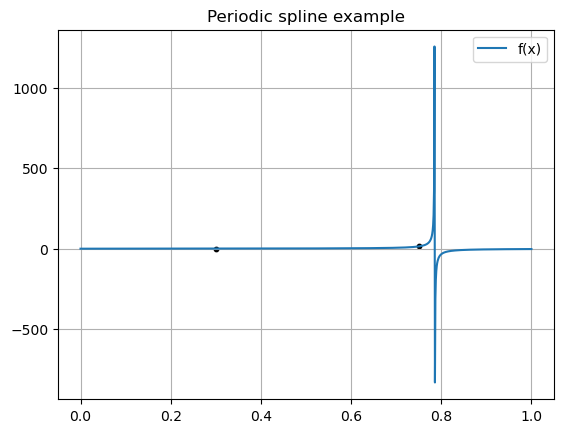

In [11]:
f = lambda x: np.tan(2*x)
f2 = lambda x: 8 / (np.cos(2*x)**4) * np.tan(2*x)  # exact f'' based on symbolic differentiation

def fd_second(x0, h=0.05):
    nodes = x0 + np.arange(-2,3)*h
    w = fdweights(np.arange(-2,3)*h, 2)     # relative coords
    return np.dot(w, [f(t) for t in nodes])

for x0 in [0.3, 0.75]:
    approx = fd_second(x0)
    exact = f2(x0)
    print(f"x={x0}:  approx={approx:.8e},  exact={exact:.8e},  error={abs(approx-exact):.2e}")

x = np.linspace(0, 1, 1001)
plt.figure()
plt.plot(x, f(x), label='f(x)')
plt.scatter(np.array([0.3, 0.75]), f(np.array([0.3, 0.75])), c='k', s=10)
plt.legend()
plt.title('Periodic spline example')
plt.grid(True)
plt.show()


The large error at $x=0.75$ stems from the proximity of $\tan(2x)$ to its first singularity at $x=\pi/4\approx0.785$.  The node set $\{x_0\pm jh\}$ therefore samples the function extremely close to the vertical asymptote, where $|f|$ and its derivatives grow rapidly, amplifying round‑off and truncation errors.